In [1]:
import os
import tensorflow as tf
from tensorflow.keras import Model, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
img_width = 224
img_height = 224
epochs = 30
epochs_ft = 60
batch_size = 32
nb_classes = 5

In [3]:
train_path = r'C:\Materials\Split\train'
validation_path = r'C:\Materials\Split\validate'
test_path = r'C:\Materials\Split\test'

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=(img_width, img_height),
    batch_size=batch_size
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_path,
    image_size=(img_width, img_height),
    batch_size=batch_size
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(img_width, img_height),
    batch_size=batch_size
)

Found 4000 files belonging to 5 classes.
Found 500 files belonging to 5 classes.
Found 500 files belonging to 5 classes.


### Preprocessing

In [5]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
])

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x / 255.0), y),
    num_parallel_calls=AUTOTUNE
).prefetch(AUTOTUNE)

validation_dataset = validation_dataset.map(
    lambda x, y: (x / 255.0, y),
    num_parallel_calls=AUTOTUNE
).prefetch(AUTOTUNE)

test_dataset = test_dataset.map(
    lambda x, y: (x / 255.0, y),
    num_parallel_calls=AUTOTUNE
).prefetch(AUTOTUNE)

In [6]:
def add_top(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(nb_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=predictions)

densenet_base = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(img_width, img_height, 3)
)

model = add_top(densenet_base)

In [7]:
def setup_model(model, base_model):
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='rmsprop',
        metrics=['accuracy']
    )

setup_model(model, densenet_base)

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

In [9]:
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 118s 802ms/step - accuracy: 0.6070 - loss: 1.3859 - val_accuracy: 0.8860 - val_loss: 0.3346 - learning_rate: 0.0010
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 100s 794ms/step - accuracy: 0.8197 - loss: 0.5190 - val_accuracy: 0.9140 - val_loss: 0.2679 - learning_rate: 0.0010
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 109s 868ms/step - accuracy: 0.8462 - loss: 0.4529 - val_accuracy: 0.9020 - val_loss: 0.2832 - learning_rate: 0.0010
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 103s 818ms/step - accuracy: 0.8629 - loss: 0.3929 - val_accuracy: 0.8800 - val_loss: 0.3983 - learning_rate: 0.0010
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 104s 828ms/step - accuracy: 0.8693 - loss: 0.3752 - val_accuracy: 0.8740 - val_loss: 0.3594 - learning_rate: 0.0010
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 104s 820ms/step - accuracy: 0.8766 - loss: 0.3441 - val_accuracy: 0.9040 - val_loss: 0.3258 - learning_rate: 0.0010
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 102s 810ms/step - accura

### DenseNet Finetuning

In [10]:
def fine_tune_model(model, base_model, trainable_layers):
    for layer in base_model.layers[:-(trainable_layers)]:
        layer.trainable = False
    for layer in base_model.layers[-(trainable_layers):]:
        layer.trainable = True

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9),
        metrics=['accuracy']
    )

fine_tune_model(model, densenet_base, 30)

In [11]:
history_ft = model.fit(
    train_dataset,
    epochs=epochs_ft,
    validation_data=validation_dataset,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.8744 - loss: 0.4364 - val_accuracy: 0.9560 - val_loss: 0.1481 - learning_rate: 1.0000e-04
Epoch 2/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 109s 869ms/step - accuracy: 0.9086 - loss: 0.2666 - val_accuracy: 0.9540 - val_loss: 0.1633 - learning_rate: 1.0000e-04
Epoch 3/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 105s 832ms/step - accuracy: 0.9231 - loss: 0.2141 - val_accuracy: 0.9540 - val_loss: 0.1646 - learning_rate: 1.0000e-04
Epoch 4/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 105s 834ms/step - accuracy: 0.9281 - loss: 0.2188 - val_accuracy: 0.9580 - val_loss: 0.1595 - learning_rate: 1.0000e-04
Epoch 5/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 102s 811ms/step - accuracy: 0.9243 - loss: 0.2203 - val_accuracy: 0.9560 - val_loss: 0.1549 - learning_rate: 1.0000e-04
Epoch 6/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 107s 849ms/step - accuracy: 0.9294 - loss: 0.1848 - val_accuracy: 0.9540 - val_loss: 0.1511 - learning_rate: 1.0000e-04
Epoch 7/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 102

In [12]:
model.save('DenseNet_model_finetuned_raw_materials.h5')

In [13]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 743ms/step - accuracy: 0.9542 - loss: 0.1459
Final Test Accuracy: 95.00%


In [14]:
loss, accuracy = model.evaluate(validation_dataset, verbose=1)

print(f"Validation Accuracy: {accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 773ms/step - accuracy: 0.9603 - loss: 0.1028
Validation Accuracy: 95.80%


## accuracy with visualization, loss curve with visualization, confusion matrix with visualization, recall, precision, f-score, ROC, AUC graph

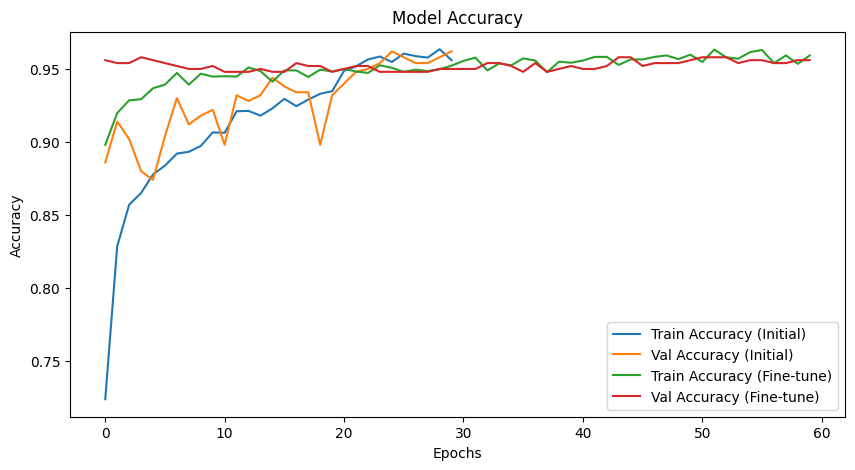

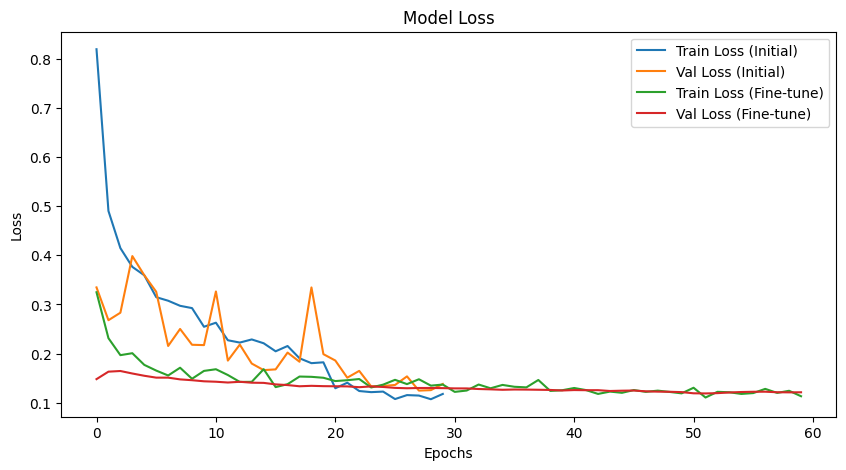

In [15]:
def plot_metrics(history, history_ft):
    # Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy (Initial)')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy (Initial)')
    plt.plot(history_ft.history['accuracy'], label='Train Accuracy (Fine-tune)')
    plt.plot(history_ft.history['val_accuracy'], label='Val Accuracy (Fine-tune)')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss (Initial)')
    plt.plot(history.history['val_loss'], label='Val Loss (Initial)')
    plt.plot(history_ft.history['loss'], label='Train Loss (Fine-tune)')
    plt.plot(history_ft.history['val_loss'], label='Val Loss (Fine-tune)')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_metrics(history, history_ft)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       100
           1       0.96      0.97      0.97       100
           2       0.98      0.94      0.96       100
           3       0.90      0.93      0.92       100
           4       0.97      0.95      0.96       100

    accuracy                           0.95       500
  

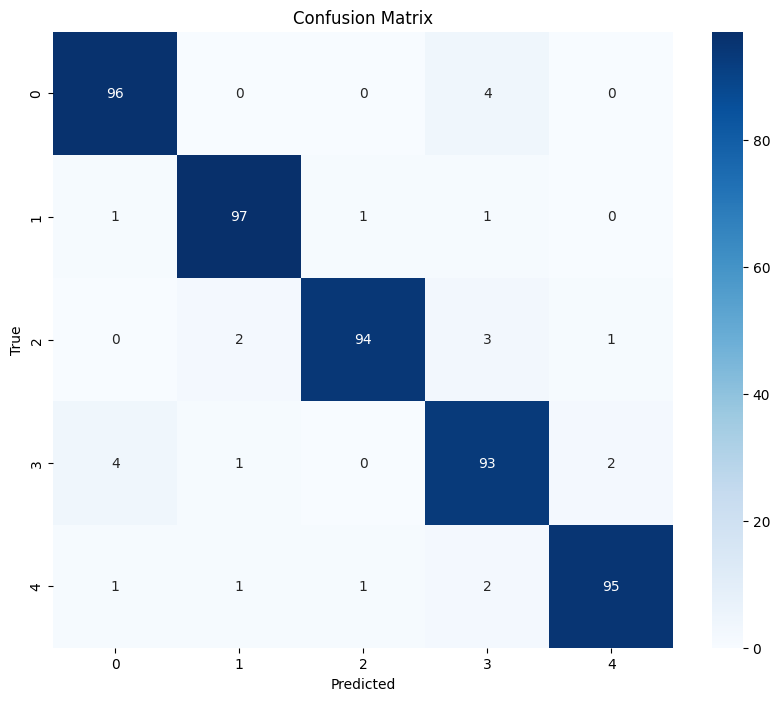

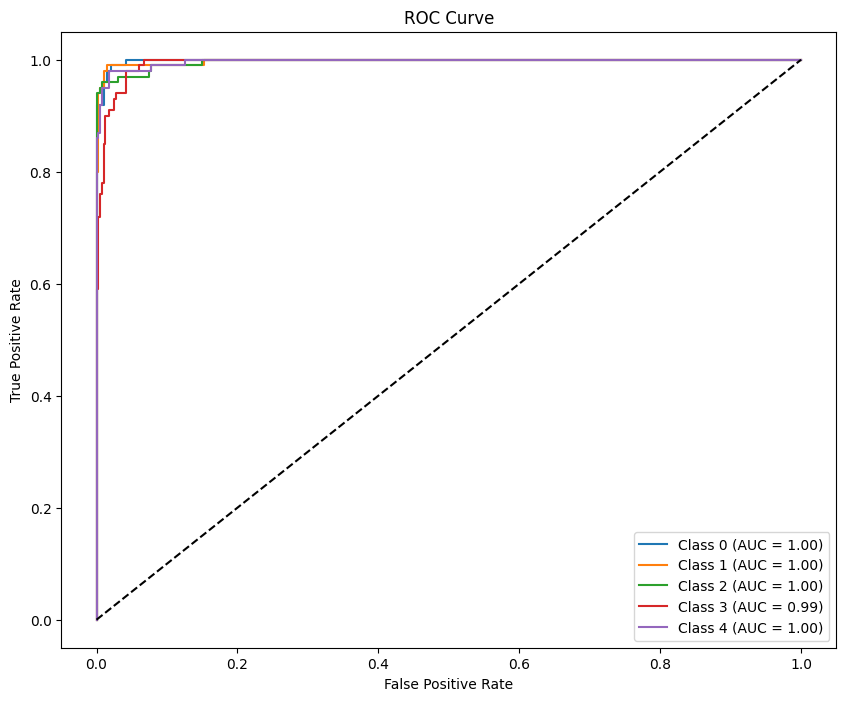

In [16]:
def evaluate_model(model, dataset):
    y_true = []
    y_pred = []
    y_probs = []

    for images, labels in dataset:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))
        y_probs.extend(predictions)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    print(classification_report(y_true, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(nb_classes), yticklabels=range(nb_classes))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC and AUC
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(nb_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(nb_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

evaluate_model(model, test_dataset)

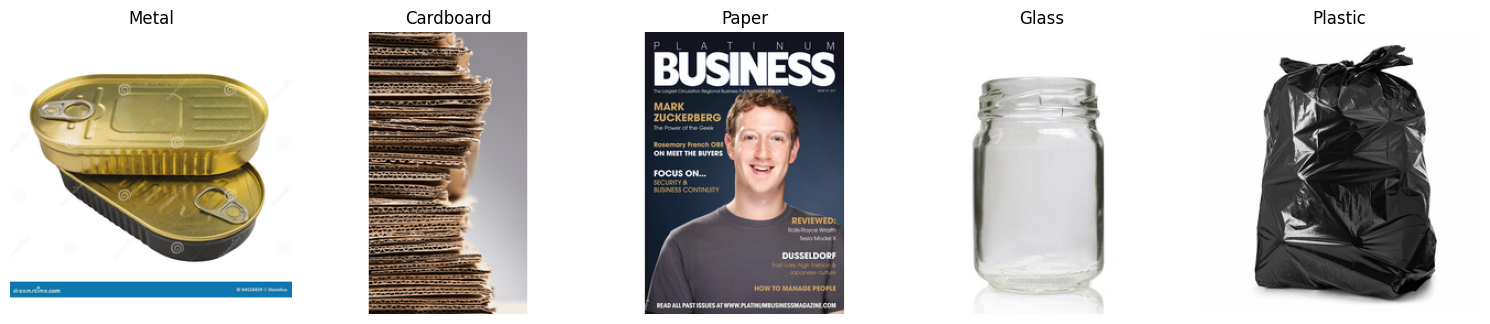

In [22]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

train_dir = r'C:\Materials\Split\train'
categories = ['Metal', 'Cardboard', 'Paper', 'Glass', 'Plastic']

fig, axes = plt.subplots(1, len(categories), figsize=(15, 5))

for i, category in enumerate(categories):
    category_train_path = os.path.join(train_dir, category)
    all_images = [file for file in os.listdir(category_train_path) if os.path.isfile(os.path.join(category_train_path, file))]
    random_image = random.choice(all_images)
    img_path = os.path.join(category_train_path, random_image)
    img = Image.open(img_path)

    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axes for clarity
    axes[i].set_title(category)

plt.tight_layout()
plt.show()